# Multi-level flow with fully-connected networks

In [1]:
from __future__ import annotations
import sys

sys.path.append("..")

import math
import logging

import torch
import torch.nn.functional as F
import pytorch_lightning as pl

# from jsonargparse.typing import PositiveInt, PositiveFloat, NonNegativeFloat

import flows.phi_four as phi_four
import flows.transforms as transforms
import flows.utils as utils
from flows.distributions import Prior, FreeScalarDistribution

Tensor: TypeAlias = torch.Tensor
BoolTensor: TypeAlias = torch.BoolTensor
Module: TypeAlias = torch.nn.Module
IterableDataset: TypeAlias = torch.utils.data.IterableDataset

logging.getLogger().setLevel("WARNING")

#%load_ext lab_black
#%load_ext tensorboard

# Definitions

In [2]:
class CouplingLayer(Module):
    def __init__(self, transform, net_spec: dict):
        super().__init__()
        self.transform = transform
        self.net_a = self.build_convnet(**net_spec)
        self.net_b = self.build_convnet(**net_spec)

    def build_convnet(
        self,
        hidden_shape: tuple[PositiveInt],
        activation: Module = torch.nn.Tanh(),
        final_activation: Module = torch.nn.Identity(),
        kernel_size: PositiveInt = 3,
        use_bias: bool = True,
    ):
        net_shape = [1, *hidden_shape, self.transform.params_dof]
        activations = [activation for _ in hidden_shape] + [final_activation]

        net = []
        for in_channels, out_channels, activation in zip(
            net_shape[:-1], net_shape[1:], activations
        ):
            convolution = torch.nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                padding=1,
                padding_mode="circular",
                stride=1,
                bias=use_bias,
            )
            net.append(convolution)
            net.append(activation)

        return torch.nn.Sequential(*net)

    def forward(self, x_full: Tensor, log_det_jacob: tensor) -> tuple[Tensor]:
        n_batch, n_channels, l1, l2 = x_full.shape
        if n_channels > 1:
            x, h = torch.tensor_split(x_full, [1], dim=1)  # take first channel
        else:
            x = x_full
        mask = utils.make_checkerboard((l1, l2)).to(x.device)
        mask_expanded = mask.view(1, 1, l1, l2)

        x_a = x[..., mask]
        x_b = x[..., ~mask]

        params_a = self.net_b(x.mul(~mask_expanded))[..., mask]
        y_a, log_det_jacob_a = self.transform(x_a, params_a)

        xy = torch.zeros_like(x)
        xy[..., mask] = y_a

        params_b = self.net_a(xy)[..., ~mask]
        y_b, log_det_jacob_b = self.transform(x_b, params_b)

        y = xy.clone()
        y[..., ~mask] = y_b

        if n_channels > 1:
            y_full = torch.cat([y, h], dim=1)
        else:
            y_full = y

        log_det_jacob.add_(log_det_jacob_a)
        log_det_jacob.add_(log_det_jacob_b)

        return y_full, log_det_jacob


class UpsamplingLayer(Module):
    def __init__(self, use_batch_dimension: bool = False):
        super().__init__()
        self.use_batch_dimension = use_batch_dimension

        kernel = torch.stack(
            [
                Tensor([[1, 0], [0, 0]]),
                Tensor([[0, 1], [0, 0]]),
                Tensor([[0, 0], [1, 0]]),
                Tensor([[0, 0], [0, 1]]),
            ],
            dim=0,
        ).unsqueeze(dim=1)
        assert kernel.shape == torch.Size([4, 1, 2, 2])

        self.register_buffer("kernel", kernel)

    def forward(self, x: Tensor, log_det_jacob: Tensor) -> tuple[Tensor]:
        """Upsample 1 lattice site -> 4 lattice sites."""
        n_batch, _, l1, l2 = x.shape
        assert (l1 % 2 == 0) and (l2 % 2 == 0)

        y = F.conv_transpose2d(x.view(-1, 4, l1, l2), self.kernel, stride=2)

        if self.use_batch_dimension:
            y = y.view(n_batch // 4, -1, 2 * l1, 2 * l2)
            log_det_jacob = log_det_jacob.view(-1, 4).sum(dim=1)

        else:
            y = y.view(n_batch, -1, 2 * l1, 2 * l2)

        return y, log_det_jacob

    def inverse(self, y: Tensor, log_det_jacob: Tensor) -> tuple[Tensor]:
        """Downsample 4 lattice sites -> 1 lattice site."""
        n_batch, _, l1, l2 = y.shape
        assert (l1 % 2 == 0) and (l2 % 2 == 0)

        x = F.conv2d(y.view(-1, 1, l1, l2), self.kernel, stride=2)

        if self.use_batch_dimension:
            x = x.view(4 * n_batch, -1, l1 // 2, l2 // 2)
            log_det_jacob_upsampled = torch.zeros(4 * log_det_jacob.shape[0], 1)
            log_det_jacob_upsampled[::4] = log_det_jacob
            log_det_jacob = log_det_jacob_upsampled
        else:
            x = x.view(n_batch, -1, l1 // 2, l2 // 2)

        return x, log_det_jacob


_test_input = torch.arange(64).view(1, 1, 8, 8).float()
_test_ldj = torch.zeros([1])
_test_layer = UpsamplingLayer(use_batch_dimension=True)
_test_out1, _test_ldj = _test_layer.inverse(_test_input, _test_ldj)
_test_out2, _test_ldj = _test_layer.inverse(_test_out1, _test_ldj)
assert torch.allclose(_test_out2[0, 0], torch.Tensor([[0, 4], [32, 36]]))
_test_out1_rt, _test_ldj = _test_layer.forward(_test_out2, _test_ldj)
assert torch.allclose(_test_out1, _test_out1_rt)
_test_input_rt, _test_ldj = _test_layer.forward(_test_out1_rt, _test_ldj)
assert torch.allclose(_test_input, _test_input_rt)
assert torch.allclose(_test_ldj, torch.zeros([1]))


class GlobalRescalingLayer(Module):
    def __init__(self):
        super().__init__()
        self.log_scale = torch.nn.Parameter(torch.tensor([0.0]))

    def forward(self, x: Tensor, log_det_jacob: Tensor) -> tuple[Tensor]:
        x.mul_(self.log_scale.exp())
        numel = utils.prod(x.shape[1:])
        log_det_jacob.add_(self.log_scale.mul(numel))
        return x, log_det_jacob

    def inverse(self, y: Tensor, log_det_jacob: Tensor) -> tuple[Tensor]:
        y.mul_(self.log_scale.neg().exp())
        numel = utils.prod(y.shape[1:])
        log_det_jacob.sub_(self.log_scale.mul(numel))
        return y, log_det_jacob

In [3]:
class MultilevelFlow(pl.LightningModule):
    def __init__(
        self,
        *,
        #m_sq: float,
        beta: float,
        lam: NonNegativeFloat,
        model_spec: list[dict | str],
        # layers: list[Module],
    ):
        super().__init__()

        layers = []
        n_upsampling = 0
        for layer_spec in reversed(model_spec):
            if layer_spec == "upsampling":
                layers.insert(0, UpsamplingLayer(use_batch_dimension=True))
                n_upsampling += 1
            elif layer_spec == "rescaling":
                layers.insert(0, GlobalRescalingLayer())
            else:
                transform = layer_spec["transform"](**layer_spec["transform_spec"])
                layer = CouplingLayer(transform, layer_spec["net_spec"])
                layers.insert(0, layer)

        self.flow = utils.Flow(*layers)
        self.n_upsampling = n_upsampling
        self.action = phi_four.PhiFourActionBeta(beta, lam)

        self.curr_iter = 0

        self.upsampling_layer = UpsamplingLayer(use_batch_dimension=True)

    def _reshape_z(self, z):
        for level in range(self.n_upsampling):
            z, _ = self.upsampling_layer.inverse(z, torch.zeros([1]))
        return z

    def log_state(self, phi):
        self.logger.experiment.add_histogram("phi", phi.flatten(), self.curr_iter)
        self.logger.experiment.add_histogram(
            "action", self.action(phi).flatten(), self.curr_iter
        )

    def forward(self, batch):
        z, log_prob_z = batch
        z = self._reshape_z(z)
        phi, log_det_jacob = self.flow(z)
        weights = log_prob_z - log_det_jacob + self.action(phi)

        self.curr_iter += 1
        if self.curr_iter % 1000 == 0:
            self.log_state(phi)

        return phi, weights

    def training_step(self, batch, batch_idx):
        _, weights = self.forward(batch)
        loss = weights.mean()
        self.log("loss", loss, logger=True)
        self.lr_schedulers().step()
        return loss

    def validation_step(self, batch, batch_idx):
        phi, weights = self.forward(batch)
        loss = weights.mean()
        acceptance = utils.metropolis_acceptance(weights)
        metrics = dict(loss=loss, acceptance=acceptance)
        self.log_dict(metrics, prog_bar=False, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.flow.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.max_steps
        )
        return [optimizer], [scheduler]

    @torch.no_grad()
    def sample(self, prior: IterableDataset, n_iter: PositiveInt = 1):
        phi, weights = self.forward(next(prior))
        for _ in range(n_iter - 1):
            _phi, _weights = self.forward(next(prior))
            phi = torch.cat((phi, _phi), dim=0)
            weights = torch.cat((weights, _weights), dim=0)
        return phi, weights

# Training

In [4]:
# Target theory
LATTICE_LENGTH = 8
# M_SQ = -4
# LAM = 0.8
BETA = 0.7
LAM = 0.5

# Model spec
ADDITIVE_BLOCK = {
    "transform": transforms.PointwiseAdditiveTransform,
    "transform_spec": {},
    "net_spec": {
        "hidden_shape": [4, 4],
        "activation": torch.nn.Tanh(),
        "final_activation": torch.nn.Identity(),
        "use_bias": False,
    },
}
AFFINE_BLOCK = {
    "transform": transforms.PointwiseAffineTransform,
    "transform_spec": {},
    "net_spec": {
        "hidden_shape": [4, 4, 4, 4],
        "activation": torch.nn.Tanh(),
        "final_activation": torch.nn.Tanh(),
        "use_bias": False,
    },
}
SPLINE_BLOCK = {
    "transform": transforms.PointwiseRationalQuadraticSplineTransform,
    "transform_spec": {"n_segments": 8, "interval": (-4, 4)},
    "net_spec": {
        "hidden_shape": [4],
        "activation": torch.nn.Tanh(),
        "final_activation": torch.nn.Identity(),
        "use_bias": True,
    },
}


MODEL_SPEC = [
    AFFINE_BLOCK,
    AFFINE_BLOCK,
    "rescaling"
]

N_TRAIN = 1000
N_BATCH = 1000
N_BATCH_VAL = 1000

In [5]:
# model = MultilevelFlow(
#     m_sq=M_SQ,
#     lam=LAM,
#     model_spec=MODEL_SPEC,
# )

model = MultilevelFlow(
    beta=BETA,
    lam=LAM,
    model_spec=MODEL_SPEC,
)
dist = torch.distributions.Normal(
    loc=torch.zeros((LATTICE_LENGTH, LATTICE_LENGTH)),
    scale=torch.ones((LATTICE_LENGTH, LATTICE_LENGTH)),
)
# dist = FreeScalarDistribution(LATTICE_LENGTH, M_SQ)
train_dataloader = Prior(dist, sample_shape=[N_BATCH, 1])
val_dataloader = Prior(dist, sample_shape=[N_BATCH_VAL, 1])

pbar = utils.JlabProgBar()
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    gpus=0,
    max_steps=N_TRAIN,  # total number of training steps
    val_check_interval=100,  # how often to run sampling
    limit_val_batches=1,  # one batch for each val step
    callbacks=[pbar, lr_monitor],
    enable_checkpointing=False,  # manually saving checkpoints
)
# print(model)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/david/miniconda3/envs/eflow/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1823: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [27]:
trainer.validate(model, val_dataloader)  # check acceptance before training starts

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       acceptance           0.04820482060313225
          loss              -58.00016403198242
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'loss': -58.00016403198242, 'acceptance': 0.04820482060313225}]

In [25]:
trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | flow             | Flow            | 2.2 K 
1 | upsampling_layer | UpsamplingLayer | 0     
-----------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
%tensorboard --logdir lightning_logs

# Freestyle

In [15]:
train_dataloader.sample().shape

torch.Size([1000, 1, 8, 8])

In [10]:
model.forward(train_dataloader.sample())

ValueError: too many values to unpack (expected 2)

In [10]:
transform = AFFINE_BLOCK["transform"](**AFFINE_BLOCK["transform_spec"])

In [278]:
batch.shape

torch.Size([10000, 1, 8, 8])

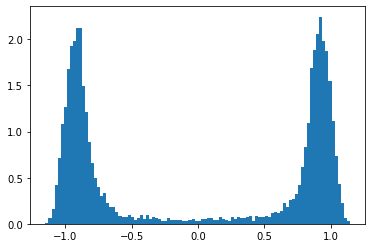

In [9]:
import matplotlib.pyplot as plt

val_dataloader = Prior(dist, sample_shape=[10000, 1])
batch = val_dataloader.sample()

flowed_batch, trash = model.flow(batch)

plt.hist(flowed_batch.mean(axis=(1,2,3)).detach().numpy(), bins=100, density=True);

In [39]:
torch.save(model.state_dict(), "b0.7-twomodes.pth")

In [8]:
model.load_state_dict(torch.load("b0.7-twomodes.pth"))

<All keys matched successfully>

In [9]:
mask = utils.make_checkerboard((8, 8))

In [15]:
mask.view(2,1,8,4).shape

torch.Size([2, 1, 8, 4])

In [19]:
a = np.array([1,2,3])
t = np.array([True,False,False])

In [20]:
a[t]

array([1])

In [21]:
a.split

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [30]:
a = torch.Tensor([1,2,3])
t = torch.full([3],False)
t[1] = True

In [29]:
torch[2]

TypeError: 'module' object is not subscriptable

In [35]:
2*False

0

In [33]:
a.mul(~t)

tensor([1., 0., 3.])

In [40]:
np.array([[1,2],[3,4]])[np.array([False,True]),...]

array([[3, 4]])

In [43]:
a.abs().neg()

tensor([-1., -2., -3.])

In [17]:
import numpy as np